In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

corpus = open('/content/drive/MyDrive/shahname2.txt', 'rb').read().decode(encoding='utf-8')
corpus = corpus.replace("\t"," \t ").replace("\n", " \n ")
vocab = sorted(set(corpus))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in corpus])
seq_length = 100
examples_per_epoch = len(corpus)//(seq_length+1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [2]:
def create_model_lstm(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE):
  model = keras.Sequential()
  #The input layer. A trainable lookup table that will map each character-ID to a vector with embedding_dim dimensions;
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]))
  model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.Dense(vocab_size))
  
  return model

In [3]:
lstm_model = create_model_lstm()
lstm_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [4]:
history = lstm_model.fit(dataset, epochs=15)

Epoch 1/15
2167/2167 [==============================] - 370s 167ms/step - loss: 1.8204 - accuracy: 0.5182
Epoch 2/15
2167/2167 [==============================] - 361s 167ms/step - loss: 1.3382 - accuracy: 0.6100
Epoch 3/15
2167/2167 [==============================] - 361s 167ms/step - loss: 1.2628 - accuracy: 0.6333
Epoch 4/15
2167/2167 [==============================] - 361s 167ms/step - loss: 1.2121 - accuracy: 0.6491
Epoch 5/15
2167/2167 [==============================] - 361s 167ms/step - loss: 1.1730 - accuracy: 0.6613
Epoch 6/15
2167/2167 [==============================] - 361s 167ms/step - loss: 1.1411 - accuracy: 0.6716
Epoch 7/15
2167/2167 [==============================] - 360s 166ms/step - loss: 1.1141 - accuracy: 0.6805
Epoch 8/15
2167/2167 [==============================] - 361s 166ms/step - loss: 1.0904 - accuracy: 0.6886
Epoch 9/15
2167/2167 [==============================] - 361s 166ms/step - loss: 1.0696 - accuracy: 0.6957
Epoch 10/15
2167/2167 [=======================

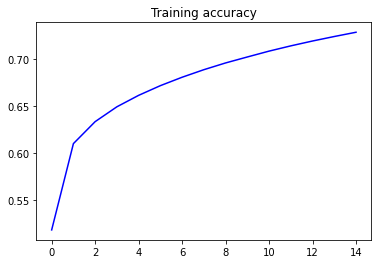

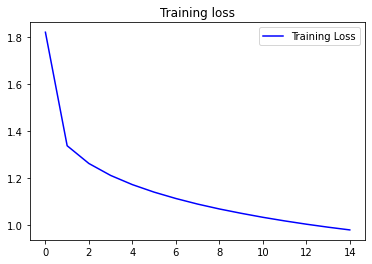

In [5]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
main_lstm_model = create_model_lstm(batch_size=1)
main_lstm_model.set_weights(lstm_model.get_weights())
main_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            12544     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           8392704   
_________________________________________________________________
dense_1 (Dense)              (1, None, 49)             50225     
Total params: 13,702,449
Trainable params: 13,702,449
Non-trainable params: 0
_________________________________________________________________


In [7]:
def generate_text(model, start_string, temperature = 1.0):
  num_generate = 1000
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))

In [17]:
txt_bychar = generate_text(main_lstm_model, start_string=u"به شبگیر هنگام بانگ خروس", temperature=1)

In [22]:
with open('by_char.txt', 'w') as f:
    f.write(txt_bychar)

In [ ]:
candidate = 'گذرها هم از تو یکی دام نیک اخترتی'
refrence = 'که با او به راه اندرون یار بود'

In [23]:
from nltk.translate.bleu_score import sentence_bleu
candidate = ['از','\t','ایدر','\t','برگشت','\t','با','\t','کی','\t','خشنود','باز','\n']
reference = ['ز','\t','درگاه','\t','برخاست','\t','آوای','\t','کوس','\n']
score = sentence_bleu(reference, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [24]:
print(score)

0.6262844962765469


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt


text = open('/content/drive/MyDrive/shahname2.txt', 'rb').read().decode(encoding='utf-8')
text = text.replace("\t"," \t ").replace("\n", " \n ")
corpusList = [w for w in text.split(' ')] 
corpus_words = [i for i in corpusList if i]
# corpus_words = corpusToList(text) 
map(str.strip, corpus_words)



In [26]:
vocab = sorted(set(corpus_words))
print('Corpus length (in words):', len(corpus_words))
print('Unique words in corpus: {}'.format(len(vocab)))
word2idx = {u: i for i, u in enumerate(vocab)}
idx2words = np.array(vocab)
word_as_int = np.array([word2idx[c] for c in corpus_words])

Corpus length (in words): 3306650
Unique words in corpus: 22718


In [27]:
seqLength = 20
examples_per_epoch = len(corpus_words)//(seqLength + 1)
wordDataset = tf.data.Dataset.from_tensor_slices(word_as_int)
sequencesOfWords = wordDataset.batch(seqLength + 1, drop_remainder=True)
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequencesOfWords.map(split_input_target)
BATCH_SIZE = 64
BUFFER_SIZE = 100
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [28]:
def generate_text(model, start_string, temperature = 1.0):
  num_generate = 200
  start_string_list =  [w for w in start_string.split(' ')]
  input_eval = [word2idx[s] for s in start_string_list]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2words[predicted_id])
  return (start_string + ' '.join(text_generated))

In [29]:
def create_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [30]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)
lstm_model.summary()
lstm_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           5815808   
_________________________________________________________________
lstm_4 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (64, None, 22718)         23285950  
Total params: 34,348,734
Trainable params: 34,348,734
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = lstm_model.fit(dataset, epochs=15)

Epoch 1/15
2460/2460 [==============================] - 311s 126ms/step - loss: 5.2351 - accuracy: 0.2266
Epoch 2/15
2460/2460 [==============================] - 309s 126ms/step - loss: 4.0201 - accuracy: 0.3005
Epoch 3/15
2460/2460 [==============================] - 312s 127ms/step - loss: 3.4248 - accuracy: 0.3590
Epoch 4/15
2460/2460 [==============================] - 313s 127ms/step - loss: 3.0283 - accuracy: 0.4117
Epoch 5/15
2460/2460 [==============================] - 311s 126ms/step - loss: 2.7289 - accuracy: 0.4582
Epoch 6/15
2460/2460 [==============================] - 311s 126ms/step - loss: 2.4893 - accuracy: 0.4994
Epoch 7/15
2460/2460 [==============================] - 311s 126ms/step - loss: 2.2909 - accuracy: 0.5355
Epoch 8/15
2460/2460 [==============================] - 311s 126ms/step - loss: 2.1173 - accuracy: 0.5692
Epoch 9/15
2460/2460 [==============================] - 311s 127ms/step - loss: 1.9715 - accuracy: 0.5990
Epoch 10/15
2460/2460 [=======================

In [32]:
main_lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
main_lstm_model.set_weights(lstm_model.get_weights())
main_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            5815808   
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_3 (Dense)              (1, None, 22718)          23285950  
Total params: 34,348,734
Trainable params: 34,348,734
Non-trainable params: 0
_________________________________________________________________


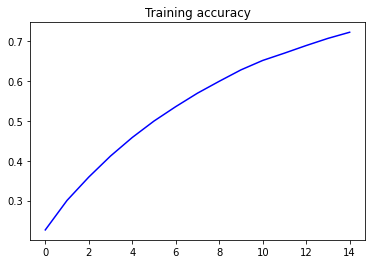

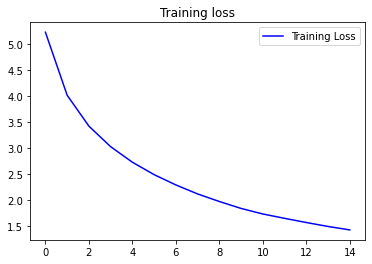

In [33]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [34]:
txt = generate_text(main_lstm_model, start_string=u"به شبگیر هنگام بانگ خروس", temperature=0.5)

In [35]:
with open('by_word.txt', 'w') as f:
    f.write(txt)

In [36]:
 from nltk.translate.bleu_score import sentence_bleu
candidate = ['ببر','\t','تا','\t','بدانند','\t','پیکارشان','\n']
reference = ['ز','\t','درگاه','\t','برخاست','\t','آوای','\t','کوس','\n']
score = sentence_bleu(reference, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [37]:
print(score)

0.7071067811865476
